<a href="https://colab.research.google.com/github/thirdformant/cats_dogs_audio/blob/master/notebooks/cats_dogs_audio_torchaudio.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Audio classification of cats and dogs

Training a machine learning classification model on images of cats and dogs is a common introductory problem. With modern convolutional neural network (CNN) architectures and transfer learning, it is now possible to achieve near-perfect levels of classification accuracy as demonstrated very effectively (and efficiently!) early on in the [fast.ai deep learning MOOC](https://course.fast.ai/). When browsing through the datasets on Kaggle some time ago, I stumbled upon the [Audio Cats and Dogs](https://www.kaggle.com/mmoreaux/audio-cats-and-dogs/home) data, which presents itself as 'the audio counterpart' to the typical image classification problem. As someone with a background in acoustic phonetics, this has rather a lot of appeal. In addition, the dataset brings some new challenges to classification:  first, the audio data requires considerable preprocessing if a CNN is to be used, and second, the data consists of only 277 files. More on both these topics later.

This notebook comprises two major parts. The first is a partial implementation of the approaches described in Huzaifah (2017) in his experimentation regarding CNN-based classification of environmental sound data. While the CNN architectures he used were implemented in TensorFlow, I have chosen instead to use Pytorch. The second section ((improves on the approaches used by Huzaifah, increasing the overall classification accuracy using TODO: finish this once the implementation is done)).

# Libraries and setup

[Librosa](http://librosa.github.io/librosa/) is a general-purpose audio processing and analysis library.

In [1]:
!apt-get install sox libsox-dev libsox-fmt-all
!pip3 install git+git://github.com/pytorch/audio

Reading package lists... Done
Building dependency tree       
Reading state information... Done
The following additional packages will be installed:
  libao-common libao4 libid3tag0 libmad0 libmagic-mgc libmagic1
  libopencore-amrnb0 libopencore-amrwb0 libsox-fmt-alsa libsox-fmt-ao
  libsox-fmt-base libsox-fmt-mp3 libsox-fmt-oss libsox-fmt-pulse libsox3
Suggested packages:
  libaudio2 file
The following NEW packages will be installed:
  libao-common libao4 libid3tag0 libmad0 libmagic-mgc libmagic1
  libopencore-amrnb0 libopencore-amrwb0 libsox-dev libsox-fmt-all
  libsox-fmt-alsa libsox-fmt-ao libsox-fmt-base libsox-fmt-mp3 libsox-fmt-oss
  libsox-fmt-pulse libsox3 sox
0 upgraded, 18 newly installed, 0 to remove and 8 not upgraded.
Need to get 1,267 kB of archives.
After this operation, 9,144 kB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu bionic/universe amd64 libopencore-amrnb0 amd64 0.1.3-2.1 [92.0 kB]
Get:2 http://archive.ubuntu.com/ubuntu bionic/un

In [0]:
import os
from pathlib import Path
from typing import Optional
from collections import Counter

import numpy as np
import pandas as pd

import librosa # Audio library

# Data viz
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.metrics import confusion_matrix

# Deep learning
import torch
import torchaudio
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data.dataset import Dataset
from torch.utils.data import DataLoader

# transforms
import torchvision.transforms as transforms
import torchaudio.transforms

In [3]:
torch.cuda.is_available()

True

In [0]:
use_cuda = True

if use_cuda and torch.cuda.is_available():
    device = torch.device("cuda")

In [5]:
# Connecting to google drive
from google.colab import drive

drive.mount('/content/gdrive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/gdrive


# Reading data

I created a csv file containing the filename and the file labels. This can be passed to the Pytorch Dataset class defined in the next section.

In [0]:
# Paths
ROOT_PATH = Path('/content/gdrive/My Drive/data/cats_dogs_audio/cats_dogs/')
CSV_PATH = Path('/content/gdrive/My Drive/data/cats_dogs_audio/all_data.csv')

In [0]:
# # Creates the csv file. Commented out because I only needed to run it once

# all_data = {
#     'label': [],
#     'filename': []
# }


# files_list = os.listdir(ROOT_PATH)
# for f in files_list:
#     if Path(f).suffix == '.wav':
#         all_data['filename'].append(f)
#         if 'cat' in f:
#             all_data['label'].append(0)
#         else:
#             all_data['label'].append(1)

# data_df = pd.DataFrame(all_data).iloc[:, ::-1] # Reverse the column order
# data_df.to_csv(CSV_PATH, index=False)

In [0]:
data_df = pd.read_csv(CSV_PATH)

In [9]:
print(f'The distribution of classes in the data is: {Counter(data_df["label"])}')

The distribution of classes in the data is: Counter({0: 164, 1: 113})


# CNN architectures

Huzaifah (2017: 3) defined two CNN architectures, with Conv-5 being deeper than Conv-3. For each network, two different convolutional filters were considered, a  $3\times3$ filter and an $M\times3$ filter where $M$ spans the FFT frequency bins. So far, only the $3\times3$ filter networks are implemented here.

In [0]:
def outputSize(in_size, kernel_size, stride, padding):

    output = int((in_size - kernel_size + 2*(padding)) / stride) + 1
    return(output)

In [0]:
class Lambda(nn.Module):
    def __init__(self, func):
        super().__init__()
        self.func = func
    
    def forward(self, x):
        return self.func(x)
    
class PrintLambda(nn.Module):
    def __init__(self, func):
        super().__init__()
        self.func = func

    def forward(self, x):
        self.func(x)
        return x

## Conv-3

### Narrowband conv-3

In [0]:
nb_conv3_model = nn.Sequential(
    nn.Conv2d(1, 180, kernel_size=3, stride=1, padding=1),
    nn.ReLU(),
    nn.MaxPool2d(kernel_size=4, stride=4, padding=1),
    nn.Dropout(0.5),
    Lambda(lambda x: x.view(-1, 180 * 9 * 13)),
    nn.Linear(180 * 9 * 13, 800),
    nn.ReLU(),
    nn.Dropout(0.5),
    nn.Linear(800, 2)
)

### Wideband conv-3

In [0]:
wb_conv3_model = nn.Sequential(
    nn.Conv2d(1, 180, kernel_size=3, stride=1, padding=1),
    nn.ReLU(),
    nn.MaxPool2d(kernel_size=4, stride=4, padding=1),
    nn.Dropout(0.5),
    Lambda(lambda x: x.view(-1, 180 * 39 * 3)),
    nn.Linear(180 * 39 * 3, 800),
    nn.ReLU(),
    nn.Dropout(0.5),
    nn.Linear(800, 2)
)

## Conv-5

### Narrowband conv-5

In [0]:
nb_conv5_model = nn.Sequential(
    nn.Conv2d(1, 24, kernel_size=3, stride=1, padding=1),
    nn.ReLU(),
    nn.MaxPool2d(kernel_size=2, stride=2, padding=1),
    nn.Dropout(0.5),
    nn.Conv2d(24, 48, kernel_size=3, stride=1, padding=1),
    nn.ReLU(),
    nn.MaxPool2d(kernel_size=2, stride=2, padding=1),
    nn.Conv2d(48, 96, kernel_size=3, stride=1, padding=1),
    nn.ReLU(),
    Lambda(lambda x: x.view(-1, 96 * 10 * 14)),
    nn.Linear(96 * 10 * 14, 800),
    nn.ReLU(),
    nn.Dropout(0.5),
    nn.Linear(800, 2)
)

### Wideband conv-5

In [0]:
wb_conv5_model = nn.Sequential(
    nn.Conv2d(1, 24, kernel_size=3, stride=1, padding=1),
    nn.ReLU(),
    nn.MaxPool2d(kernel_size=2, stride=2, padding=1),
    nn.Dropout(0.5),
    nn.Conv2d(24, 48, kernel_size=3, stride=1, padding=1),
    nn.ReLU(),
    nn.MaxPool2d(kernel_size=2, stride=2, padding=1),
    nn.Conv2d(48, 96, kernel_size=3, stride=1, padding=1),
    nn.ReLU(),
    Lambda(lambda x: x.view(-1, 96 * 40 * 4)),
    nn.Linear(96 * 40 * 4, 800),
    nn.ReLU(),
    nn.Dropout(0.5),
    nn.Linear(800, 2)
)

## CNN training functions

Defining a class for preparing the data and training the CNNs.

In [0]:
class _WrappedDataLoader:
    def __init__(self, dl, func, dev):
        self.dl = dl
        self.func = func
        self.dev = dev

    def __len__(self):
        return len(self.dl)

    def __iter__(self):
        batches = iter(self.dl)
        for b in batches:
            yield (self.func(*b, self.dev))

            

class FitCNN(object):
    """
    Functions for training a CNN
    Args:
        train_ds: pytorch Dataset of training data
        train_ds: pytorch Dataset of validation data
    """
    def __init__(self, train_ds, valid_ds, bs, preprocess_func, model, epochs,
                 loss_func, opt, dev):
        self.dev = dev
        self.train_ds = train_ds
        self.valid_ds = valid_ds
        self.bs = bs
        self.preprocess = preprocess_func
        self.model = model
        self.epochs = epochs
        self.loss_func = loss_func
        self.opt = opt
        
        self.preds = []
        self.actuals = []
        self.accuracy = []
        
    
    def fit(self):
        train_dl, valid_dl = self._get_data(self.train_ds, self.valid_ds, self.bs)
        train_dl = _WrappedDataLoader(train_dl, self.preprocess, self.dev)
        valid_dl = _WrappedDataLoader(valid_dl, self.preprocess, self.dev)
        
        if self.dev == torch.device("cuda"):
            print("Training the model on the GPU")
        else:
            print("Training the model on the CPU")
        
        self.model.apply(self._weights_init)
        for epoch in range(self.epochs):
            self.model.train()
            for xb, yb in train_dl:
                self._batch_loss(self.model, self.loss_func, xb, yb, self.opt)
            
            self.model.eval()
            with torch.no_grad():
                losses, nums = zip(
                    *[self._batch_loss(self.model, self.loss_func, xb, yb) for xb, yb in valid_dl]
                )
                val_loss = np.sum(np.multiply(losses, nums)) / np.sum(nums)
            if epoch % 5 == 0:
                print(epoch, val_loss)
        self.preds, self.actuals, self.accuracy = self._accuracy_score(valid_dl)
    
    
    def _get_data(self, train_ds, valid_ds, bs):
        return (
            DataLoader(train_ds, batch_size=bs, shuffle=True),
            DataLoader(valid_ds, batch_size=bs*2)
        )
    
    
    def _batch_loss(self, model, loss_func, xb, yb, opt=None):
        loss = loss_func(model(xb), yb)

        if opt is not None:
            loss.backward()
            opt.step()
            opt.zero_grad()

        return loss.item(), len(xb)
    
    
    def _accuracy_score(self, valid_dl):
        correct = 0
        total = 0
        preds = []
        labels = []
        with torch.no_grad():
            for data in valid_dl:
                b_images, b_labels = data
                outputs = self.model(b_images)
                _, b_predicted = torch.max(outputs.data, 1)
                total += b_labels.size(0)
                correct += (b_predicted == b_labels).sum().item()
                labels.extend(b_labels.cpu().tolist())
                preds.extend(b_predicted.cpu().cpu().tolist())
        accuracy = (100 * correct / total)
        print("-" * 40)
        print(f'Accuracy: {accuracy}')
        print(f"Confusion matrix:\n {confusion_matrix(labels, preds)}")
        print("-" * 40)
        return preds, labels, accuracy
        
        
    def _weights_init(self, m):
        if isinstance(m, nn.Conv2d):
            nn.init.xavier_uniform_(m.weight.data,
                                         nn.init.calculate_gain('relu'))
            m.bias.data.zero_()
        elif isinstance(m, nn.Linear):
            nn.init.xavier_uniform_(m.weight.data,
                                         nn.init.calculate_gain('relu'))
            m.bias.data.zero_()

### Cross validation

Class for n-fold cross-validation of CNN.

In [0]:
class CVModel:
    """
    Create and train a CNN with n-fold cross-validation
    """
    def __init__(self, X, nfolds, root, audio_trfms, image_trfms, dur,
                librosa=False, dev=None):
        self.X = X
        self.y = self.X['label']
        self.nfolds = nfolds
        
        self.root = root
        self.audio_trfms = audio_trfms
        self.image_trfms = image_trfms
        self.dur = dur
        self.librosa = librosa
        
        self.model = ''
        self.loss_func = ''
        self.opt = ''
        self.params = {}
        
        self.acc_scores = []
        self.train_preds = []
        self.train_actual = []
        
        if dev:
            self.dev = dev
        elif torch.cuda.is_available():
            self.dev = torch.device("cuda")
        else:
            self.dev = torch.device("cpu")
    
    def train_cnn(self, model, params):
        # CV setup
        self.model = model.to(self.dev)
        self.params = params
        
        skf = StratifiedKFold(n_splits=self.nfolds, random_state=42, shuffle=True)
        fold_count = 1
        
        for train_index, valid_index in skf.split(np.zeros(self.X.shape[0]), self.y):
            print(f"Fold {fold_count} / {self.nfolds}:")
            # Splits data into training and validation sets
            X_train, X_valid = self.X.iloc[train_index], self.X.iloc[valid_index]
            
            train_ds = AudioFeatureDataset(X_train, self.root,
                                           audio_transform=self.audio_trfms,
                                           image_transform=self.image_trfms,
                                           duration=self.dur,
                                           librosa=self.librosa)
                        
            valid_ds = AudioFeatureDataset(X_valid, self.root,
                                           audio_transform=self.audio_trfms,
                                           image_transform=self.image_trfms,
                                           duration=self.dur,
                                           librosa=self.librosa)
            
            # Trains the model and gets predictions and accuracy scores
            opt = optim.Adam(self.model.parameters(),
                             lr=self.params['lr'],
                             weight_decay=self.params['l2'])
            loss_func = nn.CrossEntropyLoss()
            
            model_fitter = FitCNN(train_ds, valid_ds, bs=self.params['bs'],
                                  preprocess_func=self.params['preprocess'],
                                  model=self.model,
                                  epochs=self.params['epochs'],
                                  loss_func=loss_func,
                                  opt=opt, dev=self.dev)
            
            
            model_fitter.fit()

            # Process model results
            self.train_preds.extend(model_fitter.preds)
            self.train_actual.extend(model_fitter.actuals)
            self.acc_scores.append(model_fitter.accuracy)
            fold_count += 1
            
        # Print model results summary
        print("=" * 40)
        print(f"Accuracy scores: {self.acc_scores}")
        print(f"Mean accuracy: {np.mean(self.acc_scores)}")
        print(f"Accuracy sd: {np.std(self.acc_scores)}")
        print(f"Median accuracy: {np.median(self.acc_scores)}")
        print(f"Confusion matrix:\n{confusion_matrix(self.train_actual, self.train_preds)}")
        print("-" * 40)
        print(f"Model parameters:\n {self.params}")
        print("=" * 40)

In [0]:
def preprocess_nb(x, y, dev):
    return x.view(-1, 1, 37, 50).to(dev), y.to(dev)

def preprocess_wb(x, y, dev):
    return x.view(-1, 1, 154, 12).to(dev), y.to(dev)

# CNN training

## Feature overview

Waveforms show changes in the signal, especially in its amplitude (loudness), over time and are therefore representations of the signal in the *time domain*. This is, however, only one aspect of the signal. When it comes to training audio classification or e.g. speech recognition models, better results are achieved when considering how the frequency of the signal, rather than its amplitude, changes over time. These are known as *time-frequency* representations, the best-known of which is the spectrogram.

While Huzaifah (2017) created four time-frequency representations, only two are currently implemented here:
- Linear-scaled Short-time Fourier Transform (STFT) spectrograms
- mel-scaled STFT spectrograms.

In addition, Mel-frequency Cepstral Coefficients (MFCCs) were also extracted from the input signal.

Prior to feature extractions, all raw audio was either clipped or padded to a 4 second duration.

## Pytorch dataset definition

Pytorch datasets allow the audio features to be extracted and transformed 'on the fly' when needed, rather than being extracted in advance and saved separately.

The current implementation of this allows for two options. The first uses `librosa` to load the audio data and perform the transformations. This was the approach taken by Huzaifah (2017) and so produces the most directly comparable results. However, `librosa` is limited to the CPU and is therefore slow. The second option uses the transformations in `torchaudio`, which can be run on a CUDA-compatible GPU. Being the faster option, this is the default here.

In [0]:
class AudioFeatureDataset(Dataset):
    def __init__(self, dataframe:pd.DataFrame, root_path:Path,
                 offset:int=0, duration:int=None, sr:int=16000,
                 audio_transform=None, image_transform=None,
                 librosa=False):
        """
        Args:
            dataframe: Pandas dataframe of format {labels, filename}
            root: root path for input data dir
            offset: ?
            duration: desired duration of the audio signal
            sr: desired sampling rate of the audio signal
            transform: transformations to be applied to the data
        """
        self.root = root_path
        
        self.data = dataframe
        self.files = np.array(self.data.iloc[:, 1])
        self.classes = np.array(self.data.iloc[:, 0])
        
        self.sr = sr
        self.offset = offset
        self.duration = duration
        
        self.audio_transform = audio_transform
        self.image_transform = image_transform
        self.librosa = librosa
        
        self.dev = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
        
        
    def __getitem__(self, index):
        # Stuff
        file = self.files[index]
        label = self.classes[index]
        
        if self.librosa:
            signal, sr = librosa.core.load(self.root / file, sr=self.sr,
                                       offset=self.offset,
                                       duration=self.duration)
            if self.duration:
                signal = self._pad_audio(signal)
                
            signal = self.audio_transform(signal)
            signal = np.abs(signal)
            signal = np.expand_dims(signal, axis=2)
            signal = self.image_transform(signal.astype("uint8"))
            
            
        else:
            signal = torchaudio.load(self.root / file, offset=self.offset)[0].to(self.dev)
        
            if self.duration:
                num_samples = self.sr * self.duration
                pad_trfms = transforms.Compose([
                    torchaudio.transforms.PadTrim(max_len=num_samples)])
                signal = pad_trfms(signal)
            
            signal = self.audio_transform(signal)
            signal = signal.transpose(1, 2)
            signal = self.image_transform(signal.cpu().type(torch.uint8))

        return signal, label
    

    def __len__(self):
        return len(self.files)
    
    def _pad_audio(self, signal):
        '''
        From https://stackoverflow.com/a/32477869 with comments and minor
        changes to variable names for additional clarity
        '''
        # Calculate target number of samples
        n_target = int(self.sr * self.duration)
        # Calculate number of zero samples to append
        shape = signal.shape
        # Create the target shape    
        padding = n_target - shape[0]
        #   print("Padding with %s seconds of silence" % str(N_pad/fs) )
        shape = (padding,) + shape[1:]
        # Stack only if there is something to append    
        if shape[0] > 0:                
            if len(shape) > 1:
                return np.vstack((np.zeros(shape),
                                signal))
            else:
                return np.hstack((np.zeros(shape),
                                signal))
        else:
            return signal

## Short-time Fourier Transform (STFT) features

Put very briefly, any periodic waveform can be represented by as a sum (possibly infinite) of sinusoids of different frequency and phase. Fourier transforms perform this decomposition on a signal, revealing its frequency and phase components.

Fourier transforms are typically applied to the signal as a whole and thus do not reveal how the frequency and phase components of the signal change over time. This can, however, be done with the STFT. First, the signal is divided into overlapping segments of equal length and a window function applied to these segments. The transform is then taken for each of these windows, with the complex-valued results being added to a matrix. 

The spectrogram of the signal is then defined as the magnitude (the absolute value) of the STFT matrix squared.

The STFT of a signal is given by: 

\begin{equation*}
X[m, \omega] = \sum_{k=0}^{\textrm{win_length}-1}\textrm{input}[m] \cdot \textrm{window}[n - m] \cdot \exp{\bigg(-j\frac{2\pi \cdot \omega k}{\textrm{win_length}}\bigg)}
\end{equation*}

Varying the window length (`win_length`) affects the resolution of the STFT in terms of time and frequency. Longer windows capture higher frequencies, but show less change across time (as the time domain is split into fewer windows) and shorter windows show greater change in time in exchange for lower frequency resolution. The former are known as narrowband transforms and the latter as wideband transforms.

### Linear STFT spectrograms

In linear spectrograms, the STFT frequency bins are scaled linearly which is the unmodified output of the STFT.

Both wideband (`win_length` = 512) and narrowband (`win_length` = 2048) linear spectrograms were extracted from the input signal. In both cases the window hop length was $\textrm{win_len} / 2$. The STFT values were converted to the logarithmic scale (dB) and spectrogram values were normalised to $[-1, 1]$.

The final images were resized to 37$\times$50 pixels for narrowband spectrograms and 154$\times$12 pixels for wideband spectrograms with Lanczos resampling.

In [0]:
class LinearSpectrogram(object):
    """
    Creates a spectrogram from a raw audio signal using librosa
    Args:
        sr: sample rate
        n_fft: size of fft
    """
    def __init__(self, n_fft, sr=16000, hop_length=None, center=True):
        self.n_fft = n_fft
        self.sr = sr
        self.hop_length = hop_length if hop_length else self.n_fft // 2
        self.center = center
    
    def __call__(self, sig):
        stft = np.abs(librosa.core.stft(sig, n_fft=self.n_fft,
                                        hop_length=self.hop_length,
                                        center=self.center))
        spectrogram = librosa.amplitude_to_db(stft, ref=np.max)
        return spectrogram

In [0]:
"""
Parameters and transformations for narrowband linear STFT features
"""
nb_linear_params = {
    'n_fft': 512
}

nb_lin_transform_librosa = transforms.Compose([
    LinearSpectrogram(n_fft=nb_linear_params['n_fft'])
])

nb_lin_transform = transforms.Compose([
    torchaudio.transforms.Spectrogram(ws=nb_linear_params['n_fft']),
    torchaudio.transforms.SpectogramToDB()
])

nb_image_transform = transforms.Compose([
    transforms.ToPILImage(),
    transforms.Resize((37, 50), 4),
    transforms.Grayscale(num_output_channels=1),
    transforms.ToTensor(),
    transforms.Normalize([0.5], [0.5])
])

In [0]:
"""
Parameters and transformations for wideband linear STFT features
"""

wb_linear_params = {
    'n_fft': 2048
}

wb_lin_transform_librosa = transforms.Compose([
    LinearSpectrogram(n_fft=wb_linear_params['n_fft'])
])

wb_lin_transform = transforms.Compose([
    torchaudio.transforms.Spectrogram(ws=wb_linear_params['n_fft']),
    torchaudio.transforms.SpectogramToDB()
])

wb_image_transform = transforms.Compose([
    transforms.ToPILImage(),
    transforms.Resize((154, 12), 4),
    transforms.Grayscale(num_output_channels=1),
    transforms.ToTensor(),
    transforms.Normalize([0.5], [0.5])
])

#### Narrowband: Conv-3

In [25]:
%%time
nblinear_conv3_params = {
    'bs': 40,
    'preprocess': preprocess_nb,
    'epochs': 50,
    'lr': 0.01,
    'l2': 0.005
}

nblinear_conv3 = CVModel(data_df, 5, ROOT_PATH,
                        nb_lin_transform, nb_image_transform,
                        4)
nblinear_conv3.train_cnn(nb_conv3_model,
                        nblinear_conv3_params)

Fold 1 / 5:
Training the model on the GPU
0 2.092751979827881
5 1.1619735956192017
10 0.5669213533401489
15 0.5298570990562439
20 0.49531981348991394
25 0.5233623385429382
30 0.4440250098705292
35 0.4984112083911896
40 0.4452494978904724
45 0.43203622102737427
----------------------------------------
Accuracy: 83.92857142857143
Confusion matrix:
 [[29  4]
 [ 5 18]]
----------------------------------------
Fold 2 / 5:
Training the model on the GPU
0 5.152708530426025
5 0.5642483830451965
10 0.3404325544834137
15 0.3879304826259613
20 0.26762905716896057
25 0.2525107264518738
30 0.243948832154274
35 0.29726743698120117
40 0.2576000988483429
45 0.277050644159317
----------------------------------------
Accuracy: 94.64285714285714
Confusion matrix:
 [[32  1]
 [ 2 21]]
----------------------------------------
Fold 3 / 5:
Training the model on the GPU
0 1.0053571462631226
5 2.9141790866851807
10 0.646515429019928
15 0.4534628093242645
20 0.4643685221672058
25 0.48675909638404846
30 0.4805963

#### Wideband: Conv-3

In [26]:
%%time
wblinear_conv3_params = {
    'bs': 30,
    'preprocess': preprocess_wb,
    'epochs': 40,
    'lr': 0.01,
    'l2': 0.005
}

wblinear_conv3 = CVModel(data_df, 5, ROOT_PATH,
                        wb_lin_transform, wb_image_transform,
                        4)
wblinear_conv3.train_cnn(wb_conv3_model,
                        wblinear_conv3_params)

Fold 1 / 5:
Training the model on the GPU
0 1.9237412214279175
5 0.7132323384284973
10 0.49597427248954773
15 0.511766791343689
20 0.5456759333610535
25 0.6200505495071411
30 0.5789965987205505
35 0.5380486249923706
----------------------------------------
Accuracy: 82.14285714285714
Confusion matrix:
 [[30  3]
 [ 7 16]]
----------------------------------------
Fold 2 / 5:
Training the model on the GPU
0 1.3762626647949219
5 0.3205008804798126
10 0.21794237196445465
15 0.3926255702972412
20 0.32697996497154236
25 0.2365534007549286
30 0.277342289686203
35 0.48258060216903687
----------------------------------------
Accuracy: 91.07142857142857
Confusion matrix:
 [[33  0]
 [ 5 18]]
----------------------------------------
Fold 3 / 5:
Training the model on the GPU
0 5.270444393157959
5 0.5664018392562866
10 0.4141639173030853
15 0.5024642944335938
20 0.6440936923027039
25 0.44342905282974243
30 0.41946491599082947
35 0.6324747800827026
----------------------------------------
Accuracy: 89

#### Narrowband: Conv-5

In [27]:
%%time
nblinear_conv5_params = {
    'bs': 40,
    'preprocess': preprocess_nb,
    'epochs': 40,
    'lr': 0.01,
    'l2': 0.005
}

nblinear_conv5 = CVModel(data_df, 5, ROOT_PATH,
                        nb_lin_transform, nb_image_transform,
                        4)
nblinear_conv5.train_cnn(nb_conv5_model,
                        nblinear_conv5_params)

Fold 1 / 5:
Training the model on the GPU
0 0.6959387063980103
5 0.5345904231071472
10 0.49803662300109863
15 0.4328426718711853
20 0.4722351133823395
25 0.42862582206726074
30 0.5922678112983704
35 0.39143985509872437
----------------------------------------
Accuracy: 91.07142857142857
Confusion matrix:
 [[32  1]
 [ 4 19]]
----------------------------------------
Fold 2 / 5:
Training the model on the GPU
0 0.6841724514961243
5 0.47707176208496094
10 0.3412485420703888
15 0.24678385257720947
20 0.2949652373790741
25 0.2630749046802521
30 0.20997415482997894
35 0.31942254304885864
----------------------------------------
Accuracy: 89.28571428571429
Confusion matrix:
 [[32  1]
 [ 5 18]]
----------------------------------------
Fold 3 / 5:
Training the model on the GPU
0 0.8615005612373352
5 0.5793596506118774
10 0.5002931356430054
15 0.5497934818267822
20 0.5893297791481018
25 0.38790178298950195
30 0.3490601181983948
35 0.31896063685417175
----------------------------------------
Accura

#### Wideband: Conv-5

In [29]:
%%time
wblinear_conv5_params = {
    'bs': 30,
    'preprocess': preprocess_wb,
    'epochs': 40,
    'lr': 0.005,
    'l2': 0.005
}

wblinear_conv5 = CVModel(data_df, 5, ROOT_PATH,
                        wb_lin_transform, wb_image_transform,
                        4)
wblinear_conv5.train_cnn(wb_conv5_model,
                        wblinear_conv5_params)

Fold 1 / 5:
Training the model on the GPU
0 0.6719483733177185
5 0.6349017024040222
10 0.6142798662185669
15 0.49121856689453125
20 0.4880121350288391
25 0.5019400119781494
30 0.49224525690078735
35 0.5059398412704468
----------------------------------------
Accuracy: 83.92857142857143
Confusion matrix:
 [[29  4]
 [ 5 18]]
----------------------------------------
Fold 2 / 5:
Training the model on the GPU
0 0.6908284425735474
5 0.6124641299247742
10 0.5082046985626221
15 0.35303860902786255
20 0.32355424761772156
25 0.3409222662448883
30 0.30748969316482544
35 0.2892198860645294
----------------------------------------
Accuracy: 91.07142857142857
Confusion matrix:
 [[31  2]
 [ 3 20]]
----------------------------------------
Fold 3 / 5:
Training the model on the GPU
0 0.6846070885658264
5 0.5426108837127686
10 0.5800987482070923
15 0.53333979845047
20 0.40505436062812805
25 0.4527069926261902
30 0.38134685158729553
35 0.416520357131958
----------------------------------------
Accuracy: 9

### Mel-scale STFT spectrograms

`librosa.features.melspectrogram()` was used to extract a  [mel scaled](https://en.wikipedia.org/wiki/Mel_scale)  spectrogram by applying a mel filterbank of a specified size to the STFT frequency bin values.

128 mel bands were used for narrowband spectrograms and 512 for wideband spectrograms. As with linear spectrograms values were log scaled and normalised to $[-1, 1]$. Images were resized to 37$\times$50 pixels for narrowband spectrograms and 154$\times$12 pixels for wideband spectrograms with Lanczos resampling

In [0]:
class MelSpectrogram(object):
    """
    Creates a spectrogram from a raw audio signal using librosa
    This isn't ideal but...
    Args:
        sr: sample rate
        n_fft: size of fft
    """
    def __init__(self, n_fft, n_mels, sr=16000, hop_length=None):
        self.n_fft = n_fft
        self.sr = sr
        self.hop_length = hop_length if hop_length else self.n_fft // 2
        self.n_mels = n_mels
    
    def __call__(self, sig):
        stft = np.abs(librosa.feature.melspectrogram(sig, n_fft=self.n_fft,
                                                     hop_length=self.hop_length,
                                                     n_mels=self.n_mels))
        spectrogram = librosa.amplitude_to_db(stft, ref=np.max)
        return spectrogram

In [0]:
"""
Parameters and transformations for narrowband mel STFT features
"""
nb_mel_params = {
    'n_fft': 512,
    'n_mels': 128
}

nb_mel_transform_librosa = transforms.Compose([
    MelSpectrogram(n_fft=nb_mel_params['n_fft'],
                  n_mels=nb_mel_params['n_mels'])
])

nb_mel_transform = transforms.Compose([
    torchaudio.transforms.MelSpectrogram(ws=nb_mel_params['n_fft'],
                                         n_mels=nb_mel_params['n_mels'])
])

nb_image_transform = transforms.Compose([
    transforms.ToPILImage(),
    transforms.Resize((37, 50), 4),
    transforms.Grayscale(num_output_channels=1),
    transforms.ToTensor(),
    transforms.Normalize([0.5], [0.5])
])

In [0]:
"""
Parameters and transformations for wideband mel STFT features
"""
wb_mel_params = {
    'n_fft': 2048,
    'n_mels': 512
}

wb_mel_transform_librosa = transforms.Compose([
    MelSpectrogram(n_fft=wb_mel_params['n_fft'],
                  n_mels=wb_mel_params['n_mels'])
])

wb_mel_transform = transforms.Compose([
    torchaudio.transforms.MelSpectrogram(n_fft=wb_mel_params['n_fft'],
                                         n_mels=wb_mel_params['n_mels'])
])

wb_image_transform = transforms.Compose([
    transforms.ToPILImage(),
    transforms.Resize((154, 12), 4),
    transforms.Grayscale(num_output_channels=1),
    transforms.ToTensor(),
    transforms.Normalize([0.5], [0.5])
])

#### Narrowband: Conv-3

In [33]:
%%time
nbmel_conv3_params = {
    'bs': 30,
    'preprocess': preprocess_nb,
    'epochs': 40,
    'lr': 0.01,
    'l2': 0.005
}

nbmel_conv3 = CVModel(data_df, 5, ROOT_PATH,
                        nb_mel_transform, nb_image_transform,
                        4)
nbmel_conv3.train_cnn(nb_conv3_model,
                        nbmel_conv3_params)

Fold 1 / 5:
Training the model on the GPU
0 0.7016878128051758
5 0.6243820786476135
10 0.49423959851264954
15 0.4847390949726105
20 0.4184781610965729
25 0.4872109591960907
30 0.4366031587123871
35 0.4289983808994293
----------------------------------------
Accuracy: 85.71428571428571
Confusion matrix:
 [[32  1]
 [ 7 16]]
----------------------------------------
Fold 2 / 5:
Training the model on the GPU
0 0.851533830165863
5 0.6193271279335022
10 0.4264402985572815
15 0.41130760312080383
20 0.34002217650413513
25 0.34428414702415466
30 0.25307944416999817
35 0.2608503997325897
----------------------------------------
Accuracy: 89.28571428571429
Confusion matrix:
 [[33  0]
 [ 6 17]]
----------------------------------------
Fold 3 / 5:
Training the model on the GPU
0 0.6815876960754395
5 0.648624837398529
10 0.40572816133499146
15 0.3922892212867737
20 0.3856714069843292
25 0.37773093581199646
30 0.37458422780036926
35 0.3590841293334961
----------------------------------------
Accuracy:

#### Wideband: Conv-3

In [34]:
%%time
wbmel_conv3_params = {
    'bs': 30,
    'preprocess': preprocess_wb,
    'epochs': 40,
    'lr': 0.01,
    'l2': 0.005
}

wbmel_conv3 = CVModel(data_df, 5, ROOT_PATH,
                        wb_mel_transform, wb_image_transform,
                        4)
wbmel_conv3.train_cnn(wb_conv3_model,
                        wbmel_conv3_params)

Fold 1 / 5:
Training the model on the GPU
0 0.6971888542175293
5 0.6152015924453735
10 0.47182053327560425
15 0.4439582824707031
20 0.4474715292453766
25 0.4320997893810272
30 0.4457048773765564
35 0.4560348689556122
----------------------------------------
Accuracy: 80.35714285714286
Confusion matrix:
 [[26  7]
 [ 4 19]]
----------------------------------------
Fold 2 / 5:
Training the model on the GPU
0 1.6278432607650757
5 0.6013935208320618
10 0.3782952129840851
15 0.3012264668941498
20 0.2660313546657562
25 0.2242439091205597
30 0.5055945515632629
35 0.2700257897377014
----------------------------------------
Accuracy: 91.07142857142857
Confusion matrix:
 [[32  1]
 [ 4 19]]
----------------------------------------
Fold 3 / 5:
Training the model on the GPU
0 0.8375638127326965
5 0.47018125653266907
10 0.4296555817127228
15 0.38690462708473206
20 0.4246788024902344
25 0.3984873294830322
30 0.4835050702095032
35 0.37092718482017517
----------------------------------------
Accuracy: 9

#### Narrowband: Conv-5

In [36]:
%%time
nbmel_conv5_params = {
    'bs': 30,
    'preprocess': preprocess_nb,
    'epochs': 40,
    'lr': 0.001,
    'l2': 0.005
}

nbmel_conv5 = CVModel(data_df, 5, ROOT_PATH,
                        nb_mel_transform, nb_image_transform,
                        4)
nbmel_conv5.train_cnn(nb_conv5_model,
                        nbmel_conv5_params)

Fold 1 / 5:
Training the model on the GPU
0 0.6626893281936646
5 0.6466760635375977
10 0.496099054813385
15 0.49459704756736755
20 0.4645806849002838
25 0.47265729308128357
30 0.44997552037239075
35 0.4452265799045563
----------------------------------------
Accuracy: 83.92857142857143
Confusion matrix:
 [[28  5]
 [ 4 19]]
----------------------------------------
Fold 2 / 5:
Training the model on the GPU
0 0.6648707389831543
5 0.531322181224823
10 0.40431123971939087
15 0.3214481472969055
20 0.31559258699417114
25 0.398965984582901
30 0.383230596780777
35 0.2972760498523712
----------------------------------------
Accuracy: 94.64285714285714
Confusion matrix:
 [[31  2]
 [ 1 22]]
----------------------------------------
Fold 3 / 5:
Training the model on the GPU
0 0.6682575345039368
5 0.611322820186615
10 0.5085105895996094
15 0.4536117911338806
20 0.419877827167511
25 0.48042258620262146
30 0.48438772559165955
35 0.4870491027832031
----------------------------------------
Accuracy: 75.0

#### Wideband: Conv-5

In [37]:
%%time
wbmel_conv5_params = {
    'bs': 40,
    'preprocess': preprocess_wb,
    'epochs': 40,
    'lr': 0.001,
    'l2': 0.005
}

wbmel_conv5 = CVModel(data_df, 5, ROOT_PATH,
                        wb_mel_transform, wb_image_transform,
                        4)
wbmel_conv5.train_cnn(wb_conv5_model,
                        wbmel_conv5_params)

Fold 1 / 5:
Training the model on the GPU
0 0.708220362663269
5 0.6587188839912415
10 0.5785630345344543
15 0.5322193503379822
20 0.582286536693573
25 0.5688413381576538
30 0.5906766653060913
35 0.5250605344772339
----------------------------------------
Accuracy: 82.14285714285714
Confusion matrix:
 [[27  6]
 [ 4 19]]
----------------------------------------
Fold 2 / 5:
Training the model on the GPU
0 0.7202353477478027
5 0.6716393828392029
10 0.6019241213798523
15 0.48508432507514954
20 0.36403751373291016
25 0.34811872243881226
30 0.3455410301685333
35 0.4421089291572571
----------------------------------------
Accuracy: 91.07142857142857
Confusion matrix:
 [[33  0]
 [ 5 18]]
----------------------------------------
Fold 3 / 5:
Training the model on the GPU
0 0.656867504119873
5 0.6330108642578125
10 0.5020360350608826
15 0.5446205735206604
20 0.5630818605422974
25 0.5834950804710388
30 0.5708104372024536
35 0.5613563656806946
----------------------------------------
Accuracy: 76.78

## Mel Frequency Cepstral Coefficients (MFCCs)

Along with the four spectral features, mel-frequency cepstral coefficients were also extracted from the raw audio. Per Huzaifah (2017: 2) these were 'obtained using the standard procedure'. That is by:
Huzaifah (2017: 2) writes that 'MFCCs were obtained using the standard procedure'. That is by:

1. Computing the STFT of the signal
2. Applying a mel filterbank to the power spectrum of the signal, producing the mel-scaled STFT
3. Taking the logarithm of the powers of each mel frequency
4. Taking the Discrete Cosine Transform of the list of log mel powers.

There is no implementation of MFCCs in `torchaudio`. As a result, `librosa` was used here. The default behaviour of `librosa.feature.mfcc` is to only return the first 20 MFCCs. This was left unchanged as it was assumed to be the approach used by Huzaifah. MFCC values were normalised to $[-1, 1]$ and the image resized to 37$\times$50 pixels with Lanczos resampling.

In [0]:
class MFCC(object):
    """
    Gets MFCCs from a raw audio signal using librosa
    Args:
        sr: sample rate
        n_fft: size of fft
    """
    def __init__(self, sr=16000, n_mfcc=20):
        self.sr = sr
        self.n_mfcc = n_mfcc
    
    def __call__(self, sig):
        mfcc = librosa.feature.mfcc(sig, sr=self.sr, n_mfcc=self.n_mfcc)
        return mfcc

In [0]:
mfcc_transform = transforms.Compose([
    MFCC()
])

mfcc_image_transform = transforms.Compose([
    transforms.ToPILImage(),
    transforms.Resize((37, 50), 4),
    transforms.Grayscale(num_output_channels=1),
    transforms.ToTensor(),
    transforms.Normalize([0.5], [0.5])
])

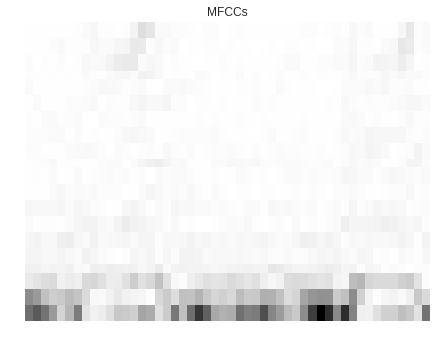

In [40]:
mfcc = AudioFeatureDataset(data_df, ROOT_PATH,
                                    audio_transform=mfcc_transform,
                                    image_transform=mfcc_image_transform,
                                    duration=4, librosa=True)
image_mfcc = mfcc.__getitem__(15)[0]

plt.imshow(image_mfcc[0], origin='lower')
plt.axis('off')
plt.title('MFCCs')
plt.show()

### MFCCs: Conv-3

In [43]:
%%time
mfcc_conv3_params = {
    'bs': 30,
    'preprocess': preprocess_nb,
    'epochs': 40,
    'lr': 0.001,
    'l2': 0.005
}

mfcc_conv3 = CVModel(data_df, 5, ROOT_PATH,
                        mfcc_transform, nb_image_transform,
                        4, librosa=True)
mfcc_conv3.train_cnn(nb_conv3_model,
               mfcc_conv3_params)

Fold 1 / 5:
Training the model on the GPU
0 1.706463098526001
5 0.6292866468429565
10 0.5988512635231018
15 0.6176655888557434
20 0.5740047097206116
25 0.5852469205856323
30 0.5508890151977539
35 0.576517641544342
----------------------------------------
Accuracy: 76.78571428571429
Confusion matrix:
 [[26  7]
 [ 6 17]]
----------------------------------------
Fold 2 / 5:
Training the model on the GPU
0 0.5657273530960083
5 0.44844862818717957
10 0.4231627285480499
15 0.41911596059799194
20 0.4156605303287506
25 0.4178639352321625
30 0.5073944926261902
35 0.4061567783355713
----------------------------------------
Accuracy: 83.92857142857143
Confusion matrix:
 [[32  1]
 [ 8 15]]
----------------------------------------
Fold 3 / 5:
Training the model on the GPU
0 0.6490617394447327
5 0.49041682481765747
10 0.4691601097583771
15 0.45807403326034546
20 0.4474366009235382
25 0.44558361172676086
30 0.42596182227134705
35 0.43565407395362854
----------------------------------------
Accuracy: 

### MFCCs: Conv-5

In [45]:
%%time
mfcc_conv5_params = {
    'bs': 30,
    'preprocess': preprocess_nb,
    'epochs': 40,
    'lr': 0.001,
    'l2': 0.005
}

mfcc_conv5 = CVModel(data_df, 5, ROOT_PATH,
                        mfcc_transform, nb_image_transform,
                        4, librosa=True)
mfcc_conv5.train_cnn(nb_conv5_model,
               mfcc_conv5_params)

Fold 1 / 5:
Training the model on the GPU
0 0.799129843711853
5 0.6764841675758362
10 0.659523069858551
15 0.663834273815155
20 0.649513840675354
25 0.7301478385925293
30 0.7419062852859497
35 0.6018915176391602
----------------------------------------
Accuracy: 71.42857142857143
Confusion matrix:
 [[24  9]
 [ 7 16]]
----------------------------------------
Fold 2 / 5:
Training the model on the GPU
0 0.7206292748451233
5 0.6219107508659363
10 0.4859585165977478
15 0.45407241582870483
20 0.4601070284843445
25 0.5108188390731812
30 0.5161507725715637
35 0.5608971118927002
----------------------------------------
Accuracy: 87.5
Confusion matrix:
 [[28  5]
 [ 2 21]]
----------------------------------------
Fold 3 / 5:
Training the model on the GPU
0 0.6690703630447388
5 0.5749691724777222
10 0.48227277398109436
15 0.4692835807800293
20 0.4648383557796478
25 0.4841438829898834
30 0.47687405347824097
35 0.48547911643981934
----------------------------------------
Accuracy: 82.14285714285714
